In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import scipy.linalg

import pyequion2
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
class TransportBuilder(object):
    def __init__(self, eqsys, TK, shear_velocity, kinematic_viscosity, cbulk, phases):
        self.eqsys = eqsys
        self.TK = TK
        self.shear_velocity = shear_velocity
        self.kinematic_viscosity = kinematic_viscosity
        self.cbulk = cbulk
        self.phases = phases
        
    def set_species(self, species_to_remove=[]):
        self.basedict = {k: v
                         for k, v in pyequion2.datamods.chemical_potentials.items()
                         if k in self.eqsys.solutes
                         and k not in species_to_remove}
        self.species = [spec for spec in eqsys.species[1:] if spec not in species_to_remove]
        self.species_ind = jnp.array([eqsys.species.index(spec) for spec in self.species])
        self.solid_ind = jnp.array([eqsys.solid_phase_names.index(phase) for phase in self.phases])
        self.reduced_formula_matrix = self.eqsys.formula_matrix[2:, self.species_ind]
        self.reduced_reaction_vector = \
            eqsys.solid_stoich_matrix[self.solid_ind, :][:, self.species_ind]
        self.closure_matrix = jnp.array(
            scipy.linalg.null_space(
                (self.reduced_formula_matrix@(self.reduced_reaction_vector.T)).T
            ).T
        )
        self.nspecies = len(self.species)
        self.logk_solid = eqsys.get_solid_log_equilibrium_constants(self.TK)[self.solid_ind]
        self.reduced_standard_potentials = eqsys.get_standard_chemical_potentials(self.TK)[self.species_ind]
        self.reduced_standard_potentials /= (pyequion2.constants.GAS_CONSTANT*self.TK)    
        self.reduce_activity_function()
        self.reduced_diffusion_coefficients = pyequion2.equilibrium_backend.diffusion_coefficients.get_diffusion_coefficients(
                                        self.species, self.TK)
        self.reduced_diffusion_coefficients = jnp.array(self.reduced_diffusion_coefficients)/self.kinematic_viscosity
        
    def reduce_activity_function(self):
        self._actfunc = pyequion2.equilibrium_backend.ACTIVITY_MODEL_MAP[eqsys.activity_model](
                            self.species, backend="jax")
        
    def activity_model_func(self, molals, TK):
        return self._actfunc(molals, TK)[..., 1:]/pyequion2.constants.LOG10E*0.0
        
    def make_grid(self, ngrid, ymax):
        self.ymax = ymax
        self.ngrid = ngrid
        self.npoints = ngrid + 1
        self.ypoints, self.ystep = jnp.linspace(0, self.ymax, self.npoints, retstep=True)
        self.ygrid = ypoints[:-1] + self.ystep/2
        
    def wall_diffusion_plus(self, yplus):
        return 9.5*1e-4*yplus**3
    
    def wall_diffusion_plus_deriv(self, yplus):
        return 3*9.5*1e-4*yplus**2
    
    def bulk_boundary_condition(self, logc, mu):
        c = jnp.exp(logc)
        cbulk = self.cbulk[..., None]
        return self.reduced_formula_matrix@(c[:, -1][..., None]) - cbulk
        
    def equilibrium_wall_boundary_condition(self, logc, mu):
        c = jnp.exp(logc)
        cm = c[:, 0]
        dc = (c[:, 1] - c[:, 0])/(self.ystep)
        dmu = (mu[:, 1] - mu[:, 0])/self.ystep
        loga = jnp.log(c[:,0]) + self.activity_model_func(c[:,0], self.TK)
        res1 = self.reduced_reaction_vector@loga - self.logk_solid[..., None]
#         res2 = self.closure_matrix@self.reduced_formula_matrix@\
#                 (dc)[..., None]
        res2 = self.closure_matrix@self.reduced_formula_matrix@\
                  (self.reduced_diffusion_coefficients*cm*dmu)[..., None]
        res = jnp.vstack([res1, res2])
        return res
    
    def modelled_wall_boundary_condition(self, logc, mu):
        c = jnp.exp(logc)
        dc = (c[:, 1] - c[:, 0])/(self.ystep)
        loga = jnp.log(c[:,0]) + self.activity_model_func(c[:,0], self.TK)
        logsatur = self.reduced_reaction_vector@loga - self.logk_solid[..., None]
        fsatur = jnp.clip(jnp.exp(logsatur)-1, 0.0, jnp.inf)*1e-3
        res = self.reduced_formula_matrix@dc[..., None] \
              - self.reduced_formula_matrix@(self.reduced_reaction_vector.T)@fsatur
        return res

    def transport_residual(self, logc, mu):
        #logc : (nsolutes, ngrid)
        #mu : (nsolutes, ngrid)
        c = jnp.exp(logc)
        ymiddle = self.ygrid[1:-1]
        cm = c[:, 1:-1]
        d1c = (c[:, 2:] - c[:, :-2])/(2*self.ystep) #(nsolutes, ngrid-2)
        d1mu = (mu[:, 2:] - mu[:, :-2])/(2*self.ystep) #(nsolutes, ngrid-2)
        d2c = (c[:, 2:] - 2*c[:, 1:-1] + c[:, :-2])/(self.ystep**2) #(nsolutes, ngrid-2
        d2mu = (mu[:, 2:] - 2*mu[:, 1:-1] + mu[:, :-2])/(self.ystep**2) #(nsolutes, ngrid-2)        
        molecular_diffusions = self.reduced_diffusion_coefficients[..., None] #(nsolutes, 1)
        turbulent_diffusions = self.wall_diffusion_plus(ymiddle)
        turbulent_diffusions_deriv = self.wall_diffusion_plus_deriv(ymiddle)
        term1 = molecular_diffusions*(d1c*d1mu + cm*d2mu)
        term2 = turbulent_diffusions*d2c + turbulent_diffusions_deriv*d1c
        term = term1 + term2
        res = self.reduced_formula_matrix@term
        return res
                
    def potential_residual(self, logc, mu):
        logg = self.activity_model_func(jnp.exp(logc).T, self.TK).T
        mu0 = self.reduced_standard_potentials[..., None]
        return mu - (mu0 + logg + logc)
    
    def full_residual(self, logcmu):
        n = logcmu.shape[0]
        logc = logcmu[:n//2, :]
        mu = logcmu[n//2:, :]
        res1a = self.equilibrium_wall_boundary_condition(logc, mu)
        res1b = self.transport_residual(logc, mu)
        res1c = self.bulk_boundary_condition(logc, mu)
        res1 = jnp.hstack([res1a, res1b, res1c])
        res3 = self.potential_residual(logc, mu)
        res = jnp.vstack([res1, res3])
        return res
    
    def bulk_residual(self, logcmu):
        n = logcmu.shape[0]
        logc = logcmu[:n//2, :]
        mu = logcmu[n//2:, :]
        res1 = self.bulk_boundary_condition(logc, mu)
        res3 = self.potential_residual(logc, mu)
        res = jnp.vstack([res1, res3])
        return res

    def gibbs_free_energy(self, logcmu):
        n = logcmu.shape[0]
        logc = logcmu[:n//2, :]
        mu = logcmu[n//2:, :]
        c = jnp.exp(logc)
        return jnp.mean(jnp.sum(c*mu, axis=0))    
    
    def flattened_equality_constraint(self, x):
        cmu = x.reshape(2*self.nspecies, self.ngrid)
        return self.full_residual(cmu).flatten()
    
    def flattened_minimization_objective(self, x):
        cmu = x.reshape(2*self.nspecies, self.ngrid)
        return self.gibbs_free_energy(cmu).flatten()[0]
        
    def wall_length(self):
        return self.kinematic_viscosity/self.shear_velocity
    
    def wall_time(self):
        return self.kinematic_viscosity/(self.shear_velocity**2)
    
    def get_log_equilibrium_constants(self, TK):
        return self.eqsys.get_log_equilibrium_constants(TK)

In [4]:
eqsys = pyequion2.EquilibriumBackend(["Na", "Cl", "Ca", "C"], from_elements=True, backend="jax", logbase="e")

In [5]:
builder = TransportBuilder(eqsys, 298.15, 0.1, 1e-6, jnp.array([1e-1, 1e-1, 1e-1, 1e-1, 0.0]), ["Calcite"])
builder.set_species(['CaCO3', 'CaHCO3+', 'CCaOH+', 'Na2CO3', 'NaCO3-', 'NaHCO3', 'NaOH', 'CaOH+',
                     'H+', 'OH-'])
builder.make_grid(100, 5)
builder.species

NameError: name 'ypoints' is not defined

In [ ]:
logc = np.ones([builder.nspecies, builder.npoints])*0.0 - 3.0
mu = builder.reduced_standard_potentials[..., None] + logc
logcmu = jnp.vstack([logc, mu])

In [6]:
constraints = {'type':'eq',
               'fun':jax.jit(builder.flattened_equality_constraint),
               'jac':jax.jit(jax.jacfwd(builder.flattened_equality_constraint))}
equality_constraint = scipy.optimize.NonlinearConstraint(
    jax.jit(builder.flattened_equality_constraint),
    lb=0.0,
    ub=0.0,
    jac = jax.jit(jax.jacfwd(builder.flattened_equality_constraint)))


In [206]:
sol = scipy.optimize.minimize(jax.jit(builder.flattened_minimization_objective),
                              logcmu.flatten(),
                              jac = jax.jit(jax.grad(builder.flattened_minimization_objective)),
                              constraints=equality_constraint,
                              method='trust-constr')

In [207]:
sol.success

False

In [208]:
logcmu = sol.x.reshape(builder.nspecies*2, builder.npoints)
logc, mu = logcmu[:builder.nspecies, :], logcmu[builder.nspecies:, :]
c = np.exp(logc)

In [209]:
builder.transport_residual(logc, mu)

DeviceArray([[ 1.41915848e-08,  4.56213911e-08,  1.19898687e-08,
               4.13037924e-08,  3.45353328e-08, -2.20157744e-07,
               1.78763003e-07, -2.94719939e-07,  1.65211532e-07,
               1.94453605e-07,  4.88871592e-08,  3.88790795e-08,
              -2.50041921e-07,  1.17644959e-07, -3.97885742e-08,
              -8.80390871e-10,  3.50992195e-08,  2.91925971e-07,
              -2.24950782e-07,  2.06709956e-08, -4.78401489e-07,
               8.47776391e-07, -6.15320459e-07,  8.54670361e-07,
              -1.57456088e-06,  7.88786565e-07,  6.93180482e-08,
               6.82777682e-07, -7.98105248e-07,  3.84930900e-07,
              -5.07441655e-07,  1.35756636e-07,  2.32296043e-06,
              -4.78516176e-06,  3.03865818e-06, -5.56778105e-07,
               1.52862776e-06, -7.09745655e-06,  1.02025606e-05,
              -3.04167770e-06, -3.95355210e-06,  5.66261497e-06,
              -2.35026664e-06, -5.57642443e-06,  5.16140335e-06,
              -4.03914328

Text(0.5, 0, '$y^+$')

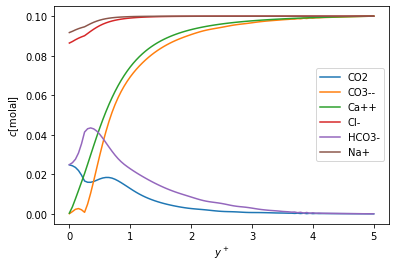

In [210]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

Text(0.5, 0, '$y^+$')

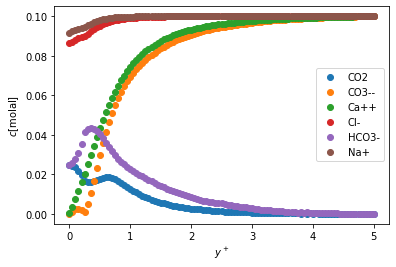

In [211]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], 'o', label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

In [220]:
c[3, :]

array([0.08639015, 0.08715439, 0.08804887, 0.08884128, 0.0895087 ,
       0.09009886, 0.09121563, 0.09234368, 0.09340308, 0.09436609,
       0.09521662, 0.09594853, 0.09657063, 0.09709742, 0.09753837,
       0.09790668, 0.09821472, 0.09847457, 0.09869624, 0.09888273,
       0.09903988, 0.09917407, 0.0992875 , 0.09938495, 0.09946748,
       0.09953956, 0.09960195, 0.09965417, 0.09969922, 0.09973775,
       0.09977079, 0.09979967, 0.0998243 , 0.09984522, 0.09986394,
       0.09987944, 0.09989327, 0.09990622, 0.09991631, 0.09992582,
       0.09993372, 0.09994158, 0.09994769, 0.09995352, 0.09995824,
       0.09996259, 0.09996612, 0.09996925, 0.09997197, 0.09997425,
       0.09997678, 0.09997902, 0.099981  , 0.09998294, 0.09998459,
       0.09998585, 0.099987  , 0.09998815, 0.09998924, 0.09999006,
       0.09999094, 0.09999183, 0.09999268, 0.09999327, 0.09999371,
       0.09999427, 0.09999488, 0.09999516, 0.09999546, 0.09999578,
       0.09999609, 0.09999635, 0.0999966 , 0.09999692, 0.09999